In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import src.data.data_cleaning as dc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib inline
import pymc3 as pm

In [10]:
raw_data = pd.read_csv('../data/external/NIOSH_Coal_Mining_Disasters_1839_to_2019.csv')
raw_data.head()

,Date,Mine Name,City,State,Killed,Product,Type
0,03/18/1839,Black Heath,Richmond,VA,53,Coal,Explosion
1,06/15/1844,Black Heath,Richmond,VA,11,Coal,Explosion
2,01/12/1846,No. 1,Carbondale,PA,14,Coal,Cave-in
3,02/19/1847,Spencer,Pottsville,PA,7,Coal,Explosion
4,11/30/1850,"Cox's Pit, Clover Hill",Winterpock,VA,7,Coal,Explosion


In [11]:
raw_data = dc.splits_datetime(raw_data)

In [12]:
raw_data.dtypes

Date         datetime64[ns]
Mine Name            object
City                 object
State                object
Killed                int64
Product              object
Type                 object
Year                  int64
dtype: object

In [29]:
deaths_per_year = raw_data.groupby(['Year']).sum()
deaths_per_year.head()

accidents_per_year = raw_data.groupby(['Year']).count()['Date']
accidents_per_year = pd.DataFrame(accidents_per_year)
accidents_per_year.columns = ['Accidents']
accidents_per_year.tail()

,Accidents
Year,
1992,1
2001,1
2006,2
2007,1
2010,1


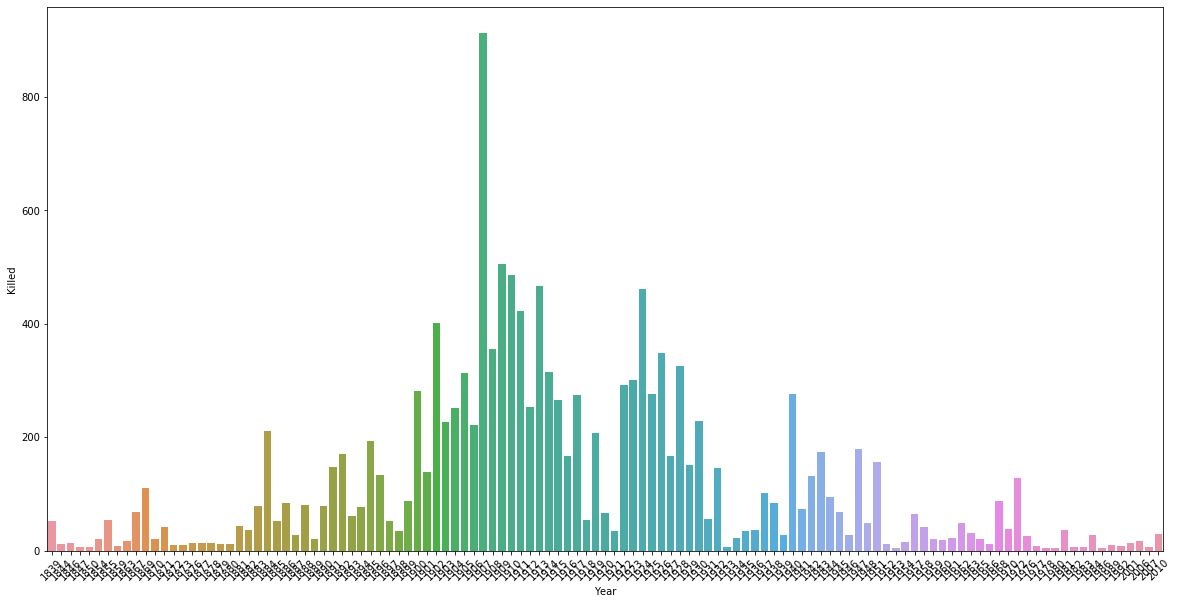

In [26]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x = deaths_per_year.index, y = 'Killed', data = deaths_per_year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()


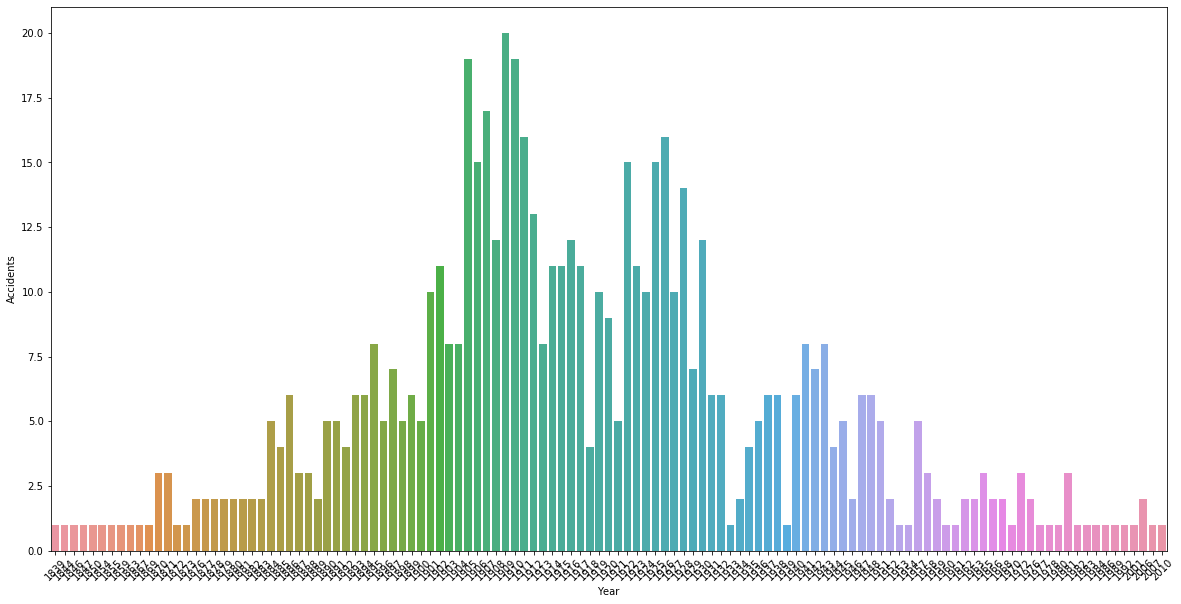

In [30]:
plt.figure(figsize=(20,10))
ax = sns.barplot(x = accidents_per_year.index, y = 'Accidents', data = accidents_per_year)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

In [31]:
print(f"Year range from: {raw_data['Year'].min()} through {raw_data['Year'].max()}").

Year range from: 1839 through 2010


Find ChangePoint

$T \sim Uniform(1839, 2010)$

$\mu_{0} \sim HalfNorm(0,4)$

$\mu_{1} \sim HalfNorm(0,4)$

$n_{t} \sim Poisson(\mu_{t > T})$

Notes: 
* Uniform distribution because we don't know what year it changes over so all are equally likely. 

* Half normal distributions for the mean of the poisson dist because mu needs to be a postive freq. 

* Poisson distribution because it is a discrete count of events occuring.

In [41]:
with pm.Model() as model:
    
    T = pm.Uniform('T', 1839, 2010)
    mu = pm.HalfNormal('mu', sigma=4, shape=2)
    group = (accidents_per_year['Accidents'].values > T) * 1
    y_obs = pm.Normal('y_obs', mu=mu[group], observed = accidents_per_year['Accidents'].values)

In [42]:
with model:
    step = pm.Slice()
    trace = pm.sample(step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [mu]
>Slice: [T]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1299.32draws/s]


/home/rob/anaconda3/envs/bayesPlayground/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/rob/anaconda3/envs/bayesPlayground/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/rob/anaconda3/envs/bayesPlayground/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/rob/anaconda3/envs/bayesPlayground/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argume

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1fd777b850>,
      dtype=object)

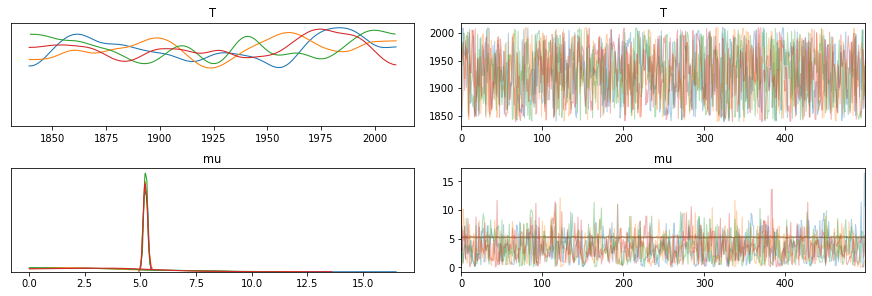

In [46]:
pm.traceplot(trace)

Figure on left is posterior density estimates for each variable.

Figure on right is results. 

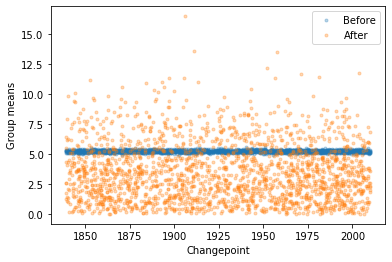

In [45]:
plt.plot(trace['T'], trace['mu'], '.', alpha=0.3)
plt.xlabel('Changepoint')
plt.legend(["Before", "After"])
plt.ylabel('Group means');

/home/rob/anaconda3/envs/bayesPlayground/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """Entry point for launching an IPython kernel.


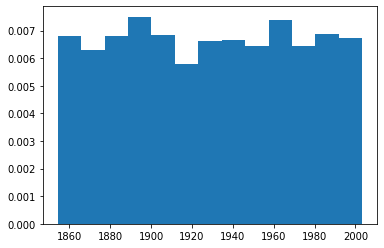

In [40]:
plt.hist(np.floor(trace['T']), bins=13, normed=True,align='left');

In [ ]:
with pm.Model() as model:
    
    T = pm.Uniform('T', 1839, 2010)
    mu = pm.HalfNormal('mu', sigma=4, shape=2)
    group = (accidents_per_year['Accidents'].values > T) * 1
    y_obs = pm.Normal('y_obs', mu=mu[group], observed = accidents_per_year['Accidents'].values)
